# Tutorial: I see your true colors

## Making and enhancing RGB images.

Have you ever heard of the overview effect? It's this state of euphoria that astronauts attain when in space, looking down at Earth, suddenly realizing the absurdity of hate and war, and the significance of life in this universe. We're not going all the way there today, but, wouldn't it be great if you could create your own ocean images that appear like you are in space, looking down? 

“True color” images are often generated with satellite imagery to visualize what an image would look like in real life, without algorithms applied. For oceans, these typically utilize red, green, and blue (RGB) bands from the satellite radiance data at the top of the atmosphere that have been corrected for the angular effects of Rayleigh scattering (also known as surface reflectance, or rhos). PACE now offers a full spectral suite of rhos products across the ultraviolet, visible, and near infrared spectra. Functionally, any three inputs can be supplied to make an “RGB” image (i.e., it does not have to be red, green, and blue), which can help create useful “false color” indices. The full range and resolution of spectral bands offered by the rhos suite are new to the ocean color community. This is an exciting prospect, enabling up to 22,100 possible unique false RGB combinations that can be derived from PACE for teasing out subtle signals of interest. 

NOTE: you will need 7.42GB configuration for this exercise.

By the end of this tutorial, you will have:

> 1. Created a contrast-stretched RGB image from PACE
> 2. Created an interactive tool for trying out different combinations
> 3. Added a layer of ocean color data on top of the RGB image 

## *Are you ready?*

## Let's go get some data first

Login to NASA Earth Access

In [1]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

For these "Level 2" files, we're downloading an individual scene, so feeding it a bounding box will help narrow down the results. Here, I'm looking for a scene off Long Island, June 28, 2024.

In [2]:
bbox = (-74.0, 40.0, -72.0, 41.0)
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L2_SFREFL",
    temporal = ("2024-06-28", "2024-06-28"),
    bounding_box = bbox
)

# Create a fileset
fileset = earthaccess.open(results);

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
fileset 

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240628T160709.L2.SFREFL.V3_0.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240628T174527.L2.SFREFL.V3_0.nc>]

So, there are two of these files. 

I actually want the second (later) one, so when I extract from the fileset later, let's extract "fileset[1]" instead of "fileset[0]" 

## Load up!

In [3]:
# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs

In [4]:
nav = xr.open_dataset(fileset[1], group="navigation_data")
nav = nav.set_coords(("longitude","latitude"))
wave = xr.open_dataset(fileset[1], group="sensor_band_parameters")
wave = wave.set_coords(("wavelength_3d"))
ds = xr.open_dataset(fileset[1], group="geophysical_data")
dataset = xr.merge((ds["rhos"], nav, wave))

#%% Subset to speed things up a bit
rhos_box = dataset.where((
        (dataset["latitude"] > 38.0)
        & (dataset["latitude"] < 42.5)
        & (dataset["longitude"] > -75.5)
        & (dataset["longitude"] < -69.0)),
    drop = True)


## Let's see what it looks like

Typically, unless there is a very strong surface reflectance signal (e.g., algal slick), visual details of the ocean are not easily distinguished from RGB rhos products without some image enhancements. Here, we're going to start by normalizing the color arrays. There are multiple ways to do this, but with ocean color images, a useful mechanism is to log transform the data and set the upper (vmax) and lower (vmin) limits.

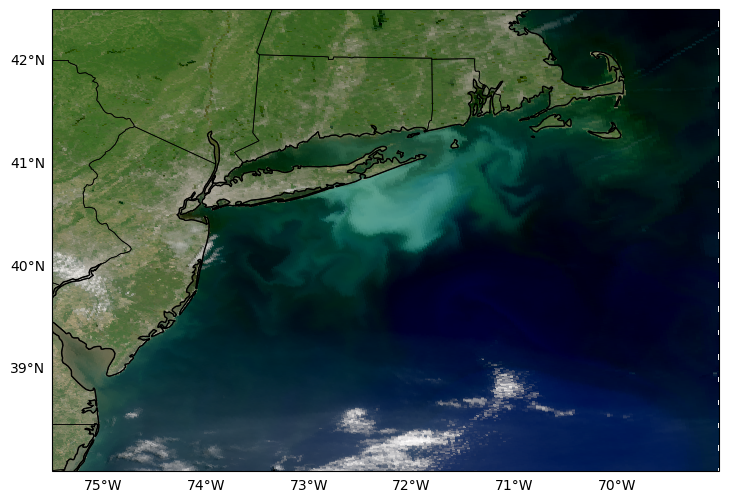

In [5]:
# This section includes code from https://pacehackweek.github.io/pace-2024/presentations/hackweek/satdata_visualization.html

# OCI True Color 1 band -min/max adjusted
vmin = 0.01
vmax = 1.04 # Above 1 because whites can be higher than 1
#---- 

rhos_red = rhos_box["rhos"].sel(wavelength_3d=645)  # Red channel at 645 nm
rhos_green = rhos_box["rhos"].sel(wavelength_3d=555)  # Green channel at 555 nm
rhos_blue = rhos_box["rhos"].sel(wavelength_3d=465)  # Blue channel at 465 nm
red = np.log(rhos_red/0.01)/np.log(1/0.01)
green = np.log(rhos_green/0.01)/np.log(1/0.01)
blue = np.log(rhos_blue/0.01)/np.log(1/0.01)
red = red.clip(min=vmin, max=vmax)
green = green.clip(min=vmin, max=vmax)
blue = blue.clip(min=vmin, max=vmax)

rgb = np.stack([red, green, blue], axis=-1)
rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb))

# Extract the longitude and latitude values for plotting
lon = rhos_box["longitude"].values
lat = rhos_box["latitude"].values

# Plot the true color image using Cartopy and Matplotlib
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree())  # Set up the map projection
gl = ax.gridlines(draw_labels=True)  # Add gridlines with labels
gl.top_labels = False  # Hide top labels
gl.right_labels = False  # Hide right labels
gl.xlines = False  # Hide x-axis lines
gl.ylines = False  # Hide y-axis lines
gl.xlabel_style = {'size': 10}  # Customize label style
gl.ylabel_style = {'size': 10}  # Customize label style

# Add state boundaries and coastlines
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
ax.coastlines()

# ---- Crop the image to preferred location ----
# Plot the RGB composite using pcolormesh and adjust brightness
#plt.pcolormesh(lon, lat, np.clip(rgb * 1.5, 0, 1), shading='auto')  # brighten with *1.5
plt.pcolormesh(lon, lat, rgb, shading='auto')
plt.xlabel("Longitude")  # Label the x-axis
plt.ylabel("Latitude")   # Label the y-axis
plt.title("RGB Composite (640, 555, 465 nm)")  # Title the plot
plt.xlim(-75.5, -69.0)  # Set longitude limits (cropping the region)
plt.ylim(38.0, 42.5)    # Set latitude limits (cropping the region)
plt.title('')  # Remove redundant title
plt.show()  # Display the plot


## Holy Coccolithophore!

What you're seeing here is a giant coccolithophore bloom. These phytoplankton create calcium carbonate shells, turning the sea a milky shade. They aren't harmful to local marine life. After they die they sink fast, making them efficient at transporting carbon into the deep ocean.

While these critter are fascinating, I have to admit that I am somewhat underwhelmed with the image quality. Let's see if we can do that thing like on fictional crime-solving shows where they "enhance!" data and find the perpetrator's identity based on the reflection of a marble in a kid's hand. Or, something to that effect. Below, we'll put in some parameters so we can adjust the image contrast, brightness, sharpness, saturation, and gamma. Let's make it pop!

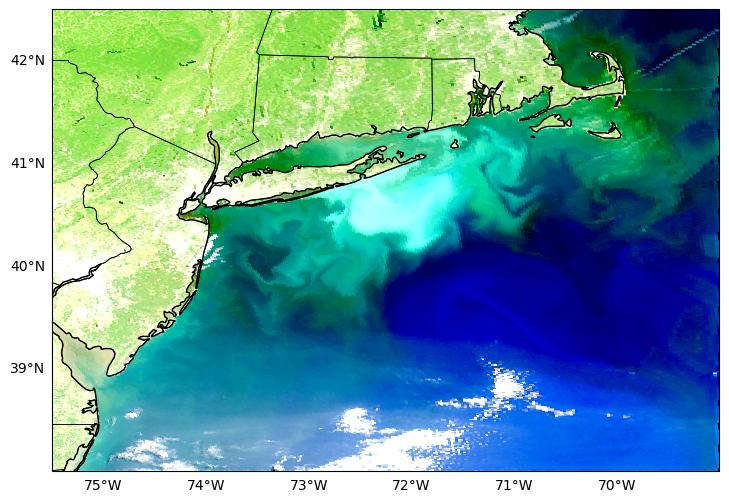

In [18]:
from PIL import Image, ImageEnhance

contrast=1.7
brightness=1.0
sharpness=2.0
saturation=1.4
gamma=0.5

rgb = np.clip(rgb, 0, 1)
rgb = np.nan_to_num(rgb, nan=0.0, posinf=1.0, neginf=0.0)
rgb_gamma = rgb ** gamma
rgb_uint8 = (rgb_gamma * 255).astype(np.uint8)

img = Image.fromarray(rgb_uint8)
img = ImageEnhance.Contrast(img).enhance(contrast)
img = ImageEnhance.Brightness(img).enhance(brightness)
img = ImageEnhance.Sharpness(img).enhance(sharpness)
img = ImageEnhance.Color(img).enhance(saturation)

enhanced_rgb = np.array(img).astype(np.float32) / 255.0

# Plot the true color image using Cartopy and Matplotlib
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree())  # Set up the map projection
gl = ax.gridlines(draw_labels=True)  # Add gridlines with labels
gl.top_labels = False  # Hide top labels
gl.right_labels = False  # Hide right labels
gl.xlines = False  # Hide x-axis lines
gl.ylines = False  # Hide y-axis lines
gl.xlabel_style = {'size': 10}  # Customize label style
gl.ylabel_style = {'size': 10}  # Customize label style

# Add state boundaries and coastlines
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
ax.coastlines()

# ---- Crop the image to preferred location ----
# Plot the RGB composite using pcolormesh and adjust brightness
#plt.pcolormesh(lon, lat, np.clip(rgb * 1.5, 0, 1), shading='auto')  # brighten with *1.5
plt.pcolormesh(lon, lat, enhanced_rgb, shading='auto')
plt.xlabel("Longitude")  # Label the x-axis
plt.ylabel("Latitude")   # Label the y-axis
plt.title("RGB Composite (640, 555, 465 nm)")  # Title the plot
plt.xlim(-75.5, -69.0)  # Set longitude limits (cropping the region)
plt.ylim(38.0, 42.5)    # Set latitude limits (cropping the region)
plt.title('')  # Remove redundant title
plt.show()  # Display the plot


# Ooooh look at me, I'm so fancy

You want to get fancy? Yeah, you want to get fancy. Let's make it a little easier to enhance this image, allowing us to spend more time exploring, and less time typing in numbers a re-running cells. For this, we're going to use ipywidgets, which allows us to be a little more interactive. We're going to redo some of what we just did above, except place it into a function, and thus be able to call it through an interactive UI. Within the interface, we'll add some options to dynamically adjust the image contrast, brightness, sharpness, saturation, and gamma with a slider bar. In addition, we'll make a dropdown menu so you can choose different wavelengths as inputs. Feel free to mess around with different color band configurations to see if you can enhance hidden features in the image! 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from ipywidgets import interact, FloatSlider, fixed, Dropdown
from PIL import Image, ImageEnhance
import xarray as xr
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import clear_output

# Constants for the true color image adjustment
vmin = 0.01
vmax = 1.04  # Above 1 because whites can be higher than 1

# Get the full list of available wavelengths (assuming 'wavelength_3d' is the coordinate)
available_wavelengths = wave["wavelength_3d"].values  # Extract wavelength values from the xarray dataset

# Function to get RGB from selected wavelengths
# We're wrapping this in a functio now because we are going to have the option to change wavelengths
def get_rgb_from_wavelengths(red_wavelength, green_wavelength, blue_wavelength):
    # Extract the respective channels (adjust according to your variable structure in rhos_box)
    rhos_red = rhos_box["rhos"].sel(wavelength_3d=red_wavelength)  # Red channel
    rhos_green = rhos_box["rhos"].sel(wavelength_3d=green_wavelength)  # Green channel
    rhos_blue = rhos_box["rhos"].sel(wavelength_3d=blue_wavelength)  # Blue channel

    # Normalize the red, green, and blue channels
    red = np.log(rhos_red / 0.01) / np.log(1 / 0.01)
    green = np.log(rhos_green / 0.01) / np.log(1 / 0.01)
    blue = np.log(rhos_blue / 0.01) / np.log(1 / 0.01)

    # Clip the values to the vmin/vmax range
    red = red.clip(min=vmin, max=vmax)
    green = green.clip(min=vmin, max=vmax)
    blue = blue.clip(min=vmin, max=vmax)

    # Stack the RGB channels and normalize to [0, 1]
    rgb = np.stack([red, green, blue], axis=-1)
    rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb))
    
    return rgb

# Function to enhance the RGB image using contrast, brightness, sharpness, saturation, and gamma
def enhance_rgb_image(rgb, contrast=1.0, brightness=1.0, sharpness=1.0, saturation=1.0, gamma=1.0):
    rgb = np.clip(rgb, 0, 1)
    rgb = np.nan_to_num(rgb, nan=0.0, posinf=1.0, neginf=0.0)
    rgb_gamma = rgb ** gamma
    rgb_uint8 = (rgb_gamma * 255).astype(np.uint8)

    img = Image.fromarray(rgb_uint8)
    img = ImageEnhance.Contrast(img).enhance(contrast)
    img = ImageEnhance.Brightness(img).enhance(brightness)
    img = ImageEnhance.Sharpness(img).enhance(sharpness)
    img = ImageEnhance.Color(img).enhance(saturation)

    enhanced_rgb = np.array(img).astype(np.float32) / 255.0
    return enhanced_rgb

# Function to plot the enhanced RGB image with Cartopy
def plot_enhanced(red_wavelength, green_wavelength, blue_wavelength, contrast, brightness, sharpness, saturation, gamma):
    # Clear the previous output to prevent scrollbars ✨
    clear_output(wait=True)

    # Re-create the RGB composite based on current dropdown selection
    rgb = get_rgb_from_wavelengths(red_wavelength, green_wavelength, blue_wavelength)

    # Apply enhancements using the slider values (this was the missing step) 🛠️
    enhanced_rgb = enhance_rgb_image(rgb, contrast, brightness, sharpness, saturation, gamma)

    # 4. Get map coordinates
    lon = rhos_box["longitude"].values
    lat = rhos_box["latitude"].values

    # Create the plot
    plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
    ax.coastlines()
    plt.pcolormesh(lon, lat, enhanced_rgb, shading='auto')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xlim(-75.5, -69.0)
    plt.ylim(38.0, 42.5)
    plt.title('')
    plt.show()

# Interactive widget for enhancing the image using sliders
interact(
    plot_enhanced,
    red_wavelength=Dropdown(options=available_wavelengths, value=645, description='Red Wavelength'),
    green_wavelength=Dropdown(options=available_wavelengths, value=555, description='Green Wavelength'),
    blue_wavelength=Dropdown(options=available_wavelengths, value=465, description='Blue Wavelength'),
    contrast=FloatSlider(min=0.5, max=3, step=0.1, value=1.0, description="Contrast"),
    brightness=FloatSlider(min=0.5, max=3, step=0.1, value=1.0, description="Brightness"),
    sharpness=FloatSlider(min=0.5, max=3, step=0.1, value=1.0, description="Sharpness"),
    saturation=FloatSlider(min=0.5, max=3, step=0.1, value=1.0, description="Saturation"),
    gamma=FloatSlider(min=0.1, max=2, step=0.05, value=1.0, description="Gamma"),
)


interactive(children=(Dropdown(description='Red Wavelength', index=56, options=(np.float64(346.0), np.float64(…

<function __main__.plot_enhanced(red_wavelength, green_wavelength, blue_wavelength, contrast, brightness, sharpness, saturation, gamma)>

## Enhancing ocean color data images with true color

Okay, just to make your ocean color images a little more fun, you can actually grab an ocean color variable and put it on top of and RGB image. Let's start with grabbing the chlorophyll data and subsetting it the same way we did with the rhos data. 

In [19]:
bbox = (-74.0, 40.0, -72.0, 41.0)
import xarray as xr
results2 = earthaccess.search_data(
    short_name = "PACE_OCI_L2_BGC",
    temporal = ("2024-06-28", "2024-06-28"),
    bounding_box = bbox
)
fileset2 = earthaccess.open(results2);

# Create a fileset
fileset2 = earthaccess.open(results2);
#ds2 = xr.open_dataset(fileset2[1])
ds_chl = xr.open_dataset(fileset2[1], group="geophysical_data")
chlor_a = xr.merge((ds_chl["chlor_a"], nav, wave))
chlor_box = chlor_a.where((
        (chlor_a["latitude"] > 38.0)
        & (chlor_a["latitude"] < 42.5)
        & (chlor_a["longitude"] > -75.5)
        & (chlor_a["longitude"] < -69.0)),
    drop=True)

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

What is very convenient is that the chlorophyll image has NaNs when data are not present. So, we can just grab the all the valid datapoints using np.isfinite, and plop that right on top of our original RGB image, preserving the true color image where chlor_a = NaN.

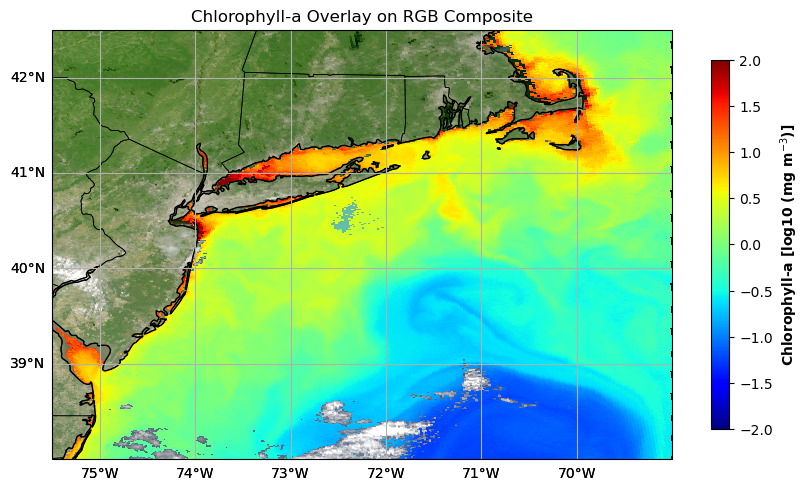

In [21]:
# Normalize chlorophyll-a
chlor_a = chlor_box["chlor_a"]
chlor_mask = np.isfinite(chlor_a)
chlor_display = chlor_a.where(chlor_mask)

# Start figure
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=cartopy.crs.PlateCarree())

# Gridlines and features
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
ax.coastlines()
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})

# Plot RGB background
plt.pcolormesh(lon, lat, np.clip(rgb * 1.2, 0, 1), shading='auto')

# Overlay chlorophyll-a where valid
chlor_plot = ax.pcolormesh(
    lon, lat, np.log10(chlor_display),
    cmap='jet',
    shading='auto',
    vmin=-2, vmax=2
    #alpha=np.where(chlor_mask, 0.7, 0)  # Use alpha mask for transparency
)

# Optional colorbar
cbar = plt.colorbar(chlor_plot, ax=ax, shrink=0.8, pad=0.05)
cbar.set_label('Chlorophyll-a [log10 (mg m$^{-3}$)]', weight='bold')

# Labels and limits
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-75.5, -69.0)
plt.ylim(38.0, 42.5)
plt.title('Chlorophyll-a Overlay on RGB Composite')
plt.show()

## There you have it! 

The surface reflectance products can be very useful because they have minimal atmospheric correction applied, that is, no aerosol subtraction, which is a source of common data quality errors. Some algorithm developers prefer to use rhos in place of remote sensing reflectance, especially for inland water bodies where atmospheric correction can be very challenging, as is the case for cyanobacteria monitoring. Feel free to go back and change the RGB channels to a customized combination, it doesn't have to be red, green, and blue. Or, try reading in Rrs (PACE*AOP files) instead of rhos, and then you can really emphasize ocean features!